#General Initialization (Run)

In [1]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
import pandas as pd
import glob 
from sklearn.metrics import confusion_matrix
import IPython.display as ipd  # To play sound in the notebook
import os
import sys
import warnings
# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import transforms, utils
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torch
from torchsummary import summary
import torch.optim as optim
from torch.autograd import Variable
from IPython.display import clear_output
from torch.utils.tensorboard import SummaryWriter
import tqdm.notebook as tq
from sklearn.preprocessing import minmax_scale

from sklearn import metrics
from sklearn.metrics import confusion_matrix

from collections import Counter

In [2]:
# mounting drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# modify "customized_path_to_project", path of folder in drive, where you have stored your project
customized_path_to_project = "/content/drive/MyDrive/apple_farm"
sys.path.append(customized_path_to_project)

# Data Exploration (Run)

Importing the dataset<br>

1. Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
Vocal channel (01 = speech, 02 = song).
2. Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
3. Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
4. Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
5. Repetition (01 = 1st repetition, 02 = 2nd repetition).
6. Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

In [4]:
RAVDESS = os.path.join(customized_path_to_project, "ravdess", "data")

# Looking at folders in this directory (should be 24) 
list_dir = os.listdir(RAVDESS)
list_dir.sort()
print(f"DIR Name: {list_dir}\n") # Actor 1 - Actor 24

emotion = []
gender = []
path = []
c = 1

for i in list_dir:
  filename = os.listdir(RAVDESS +'/' + i) #files in 'Actor 1' type folders (03-01-01-01-01-01-01.wav) 
  print(f"Counter :{c}\nFilename :{filename}\nNumber of .wav files: {len(filename)}\n\n")
  c += 1 
  for f in filename:    
    part = f.split('.')[0].split('-')  #getting labels i.e. 03 01 02 ... from "03-01-01-01-01-01-01.wav"      
    emotion.append(int(part[2]))

    try:
      temp = int(part[6])
    except ValueError:
      print(f"{f} 파일명 중복 처리")
      gen = part[6].split(" ")[0]
      temp = int(gen)

    if temp % 2 == 0:
      temp = "female"
    else:
      temp = "male"
    gender.append(temp)
    path.append(RAVDESS + '/' + i + '/' + f)

DIR Name: ['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_18', 'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24']

Counter :1
Filename :['03-01-05-02-01-01-01.wav', '03-01-03-02-02-01-01.wav', '03-01-02-02-01-02-01.wav', '03-01-03-02-01-01-01.wav', '03-01-01-01-01-01-01.wav', '03-01-04-02-01-01-01.wav', '03-01-05-02-01-02-01.wav', '03-01-02-01-01-02-01.wav', '03-01-02-01-01-01-01.wav', '03-01-04-01-02-01-01.wav', '03-01-01-01-01-02-01.wav', '03-01-05-01-02-01-01.wav', '03-01-05-01-02-02-01.wav', '03-01-05-01-01-01-01.wav', '03-01-04-01-01-01-01.wav', '03-01-04-02-01-02-01.wav', '03-01-05-02-02-02-01.wav', '03-01-05-02-02-01-01.wav', '03-01-03-02-02-02-01.wav', '03-01-01-01-02-01-01.wav', '03-01-02-02-01-01-01.wav', '03-01-04-01-02-02-01.wav', '03-01-02-02-02-01-01.wav', '03-01-04-02-02-01-01.wav', '03-01

##Putting necessary information into Data Frames and saving to csv files

In [5]:
data_frame = RAVDESS_df = pd.DataFrame(path)
data_frame = pd.concat([pd.DataFrame(gender), RAVDESS_df], axis=1)
data_frame.columns = ['gender','path']
print(data_frame)

      gender                                               path
0       male  /content/drive/MyDrive/apple_farm/ravdess/data...
1       male  /content/drive/MyDrive/apple_farm/ravdess/data...
2       male  /content/drive/MyDrive/apple_farm/ravdess/data...
3       male  /content/drive/MyDrive/apple_farm/ravdess/data...
4       male  /content/drive/MyDrive/apple_farm/ravdess/data...
...      ...                                                ...
1452  female  /content/drive/MyDrive/apple_farm/ravdess/data...
1453  female  /content/drive/MyDrive/apple_farm/ravdess/data...
1454  female  /content/drive/MyDrive/apple_farm/ravdess/data...
1455  female  /content/drive/MyDrive/apple_farm/ravdess/data...
1456  female  /content/drive/MyDrive/apple_farm/ravdess/data...

[1457 rows x 2 columns]


##Seperating out *male* and *female* voices

In [6]:
data_frame_male = data_frame.loc[data_frame['gender'] == 'male']
print(data_frame_male)
data_frame_male.to_csv('male.csv', index=False) 

     gender                                               path
0      male  /content/drive/MyDrive/apple_farm/ravdess/data...
1      male  /content/drive/MyDrive/apple_farm/ravdess/data...
2      male  /content/drive/MyDrive/apple_farm/ravdess/data...
3      male  /content/drive/MyDrive/apple_farm/ravdess/data...
4      male  /content/drive/MyDrive/apple_farm/ravdess/data...
...     ...                                                ...
1392   male  /content/drive/MyDrive/apple_farm/ravdess/data...
1393   male  /content/drive/MyDrive/apple_farm/ravdess/data...
1394   male  /content/drive/MyDrive/apple_farm/ravdess/data...
1395   male  /content/drive/MyDrive/apple_farm/ravdess/data...
1396   male  /content/drive/MyDrive/apple_farm/ravdess/data...

[730 rows x 2 columns]


In [7]:
data_frame_female = data_frame.loc[data_frame['gender'] == 'female']
data_frame_female.to_csv('female.csv', index=False) 
print(data_frame_female)

      gender                                               path
62    female  /content/drive/MyDrive/apple_farm/ravdess/data...
63    female  /content/drive/MyDrive/apple_farm/ravdess/data...
64    female  /content/drive/MyDrive/apple_farm/ravdess/data...
65    female  /content/drive/MyDrive/apple_farm/ravdess/data...
66    female  /content/drive/MyDrive/apple_farm/ravdess/data...
...      ...                                                ...
1452  female  /content/drive/MyDrive/apple_farm/ravdess/data...
1453  female  /content/drive/MyDrive/apple_farm/ravdess/data...
1454  female  /content/drive/MyDrive/apple_farm/ravdess/data...
1455  female  /content/drive/MyDrive/apple_farm/ravdess/data...
1456  female  /content/drive/MyDrive/apple_farm/ravdess/data...

[727 rows x 2 columns]


Playing audio file and plotting it to look at the output

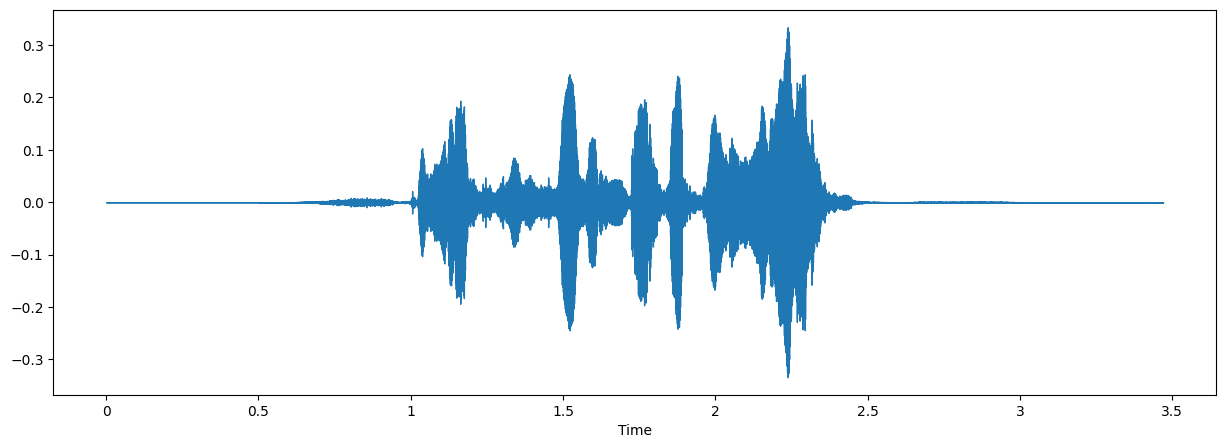

In [8]:
# Picking a fearful track
fname = RAVDESS + '/' + 'Actor_14/03-01-06-02-02-02-14.wav'  
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)

# Playing the audio 
ipd.Audio(fname)

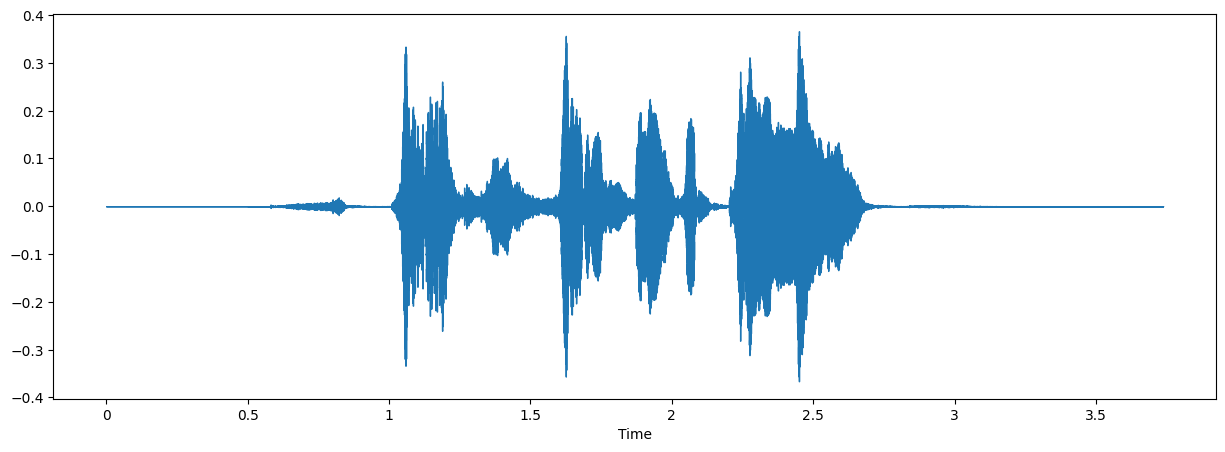

In [9]:
# Picking a happy track
fname = RAVDESS + '/' + 'Actor_14/03-01-03-02-02-02-14.wav'  
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)

# Playing the audio 
ipd.Audio(fname)

# Feature Extraction (Run)

Using MFCC - Mel -frequency Cepstarl Coefficient

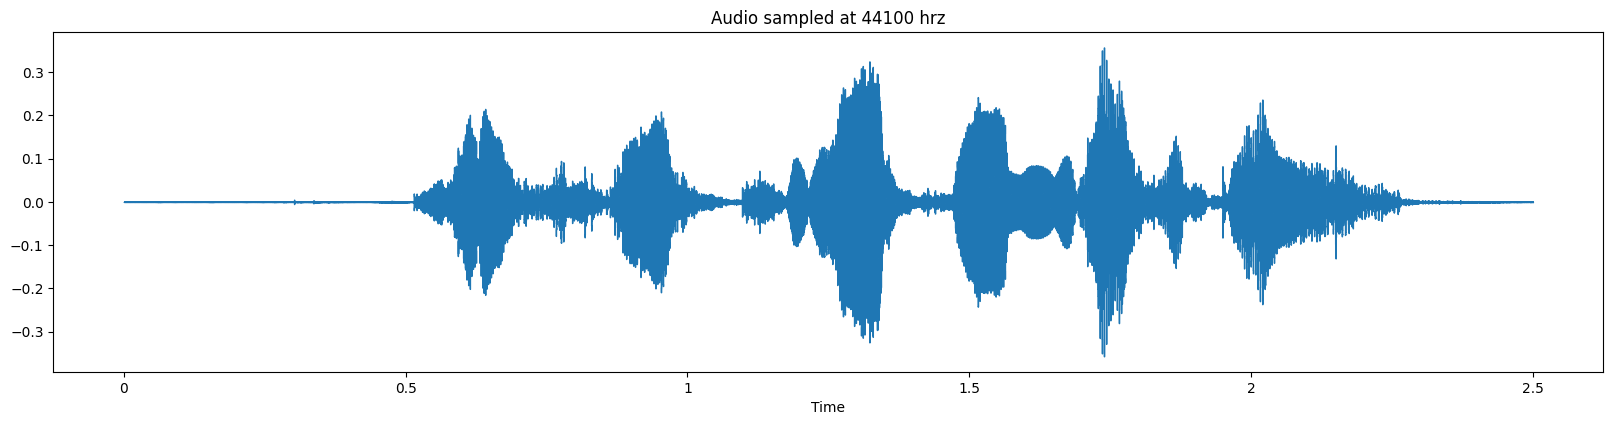

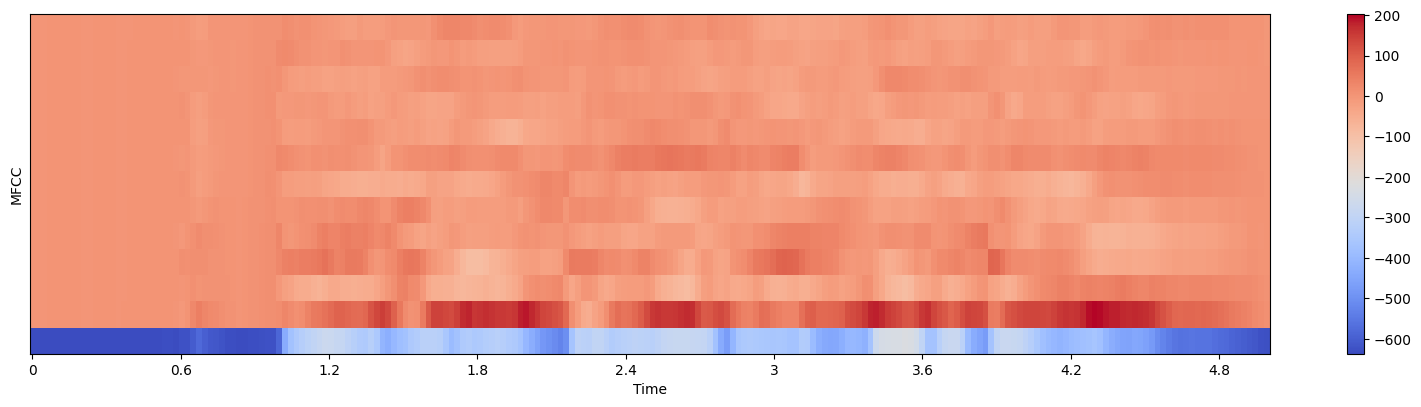

In [10]:
# Source - RAVDESS; Gender - Female; Emotion - Angry 
pathf = os.path.join(customized_path_to_project,"ravdess/data/Actor_08/03-01-05-02-01-01-08.wav")
Xf, sample_ratef = librosa.load(pathf, duration=2.5,sr=22050*2,offset=0.5)  
mfcc = librosa.feature.mfcc(y=Xf, sr=sample_ratef, n_mfcc=13)

# audio wave
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.waveshow(Xf, sr=sample_ratef)
plt.title('Audio sampled at 44100 hrz')

# MFCC
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()
ipd.Audio(pathf)

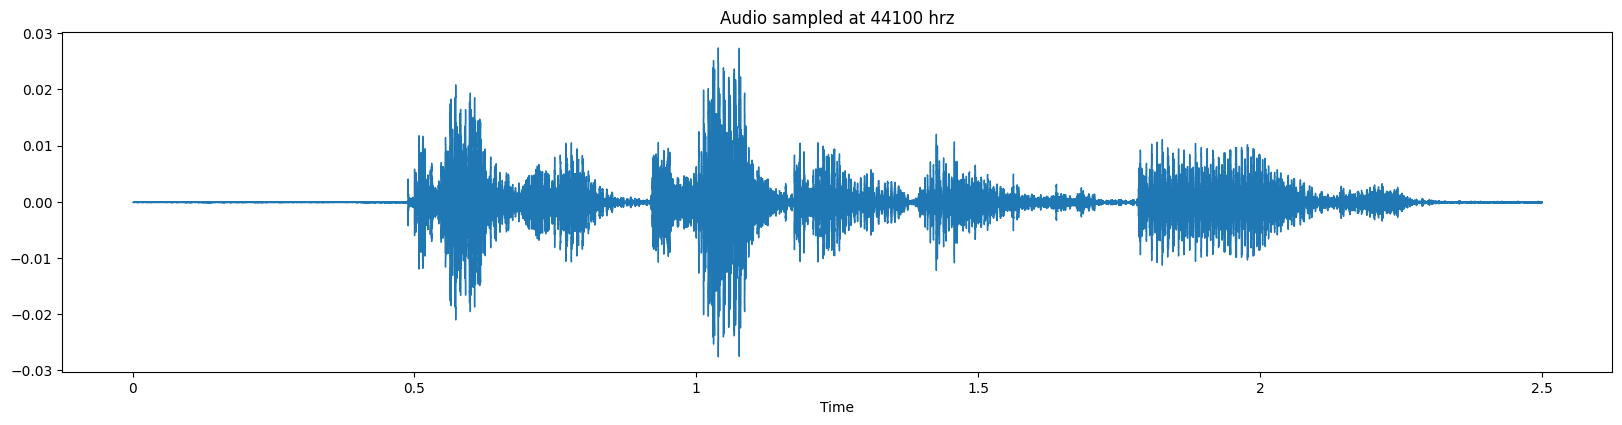

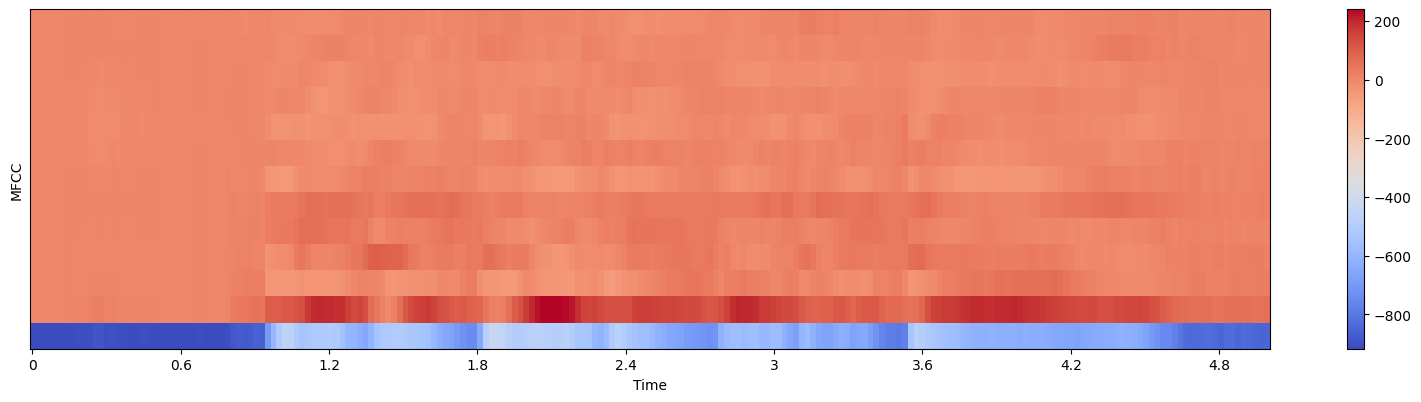

In [11]:
# Source - RAVDESS; Gender - Male; Emotion - Angry 
pathm = os.path.join(customized_path_to_project,"ravdess/data/Actor_09/03-01-05-01-01-01-09.wav")
Xm, sample_ratem = librosa.load(pathm, duration=2.5,sr=22050*2,offset=0.5)  
mfcc = librosa.feature.mfcc(y=Xm, sr=sample_ratem, n_mfcc=13)

# audio wave
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.waveshow(Xm, sr=sample_ratem)
plt.title('Audio sampled at 44100 hrz')

# MFCC
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()
ipd.Audio(pathm)

216
216


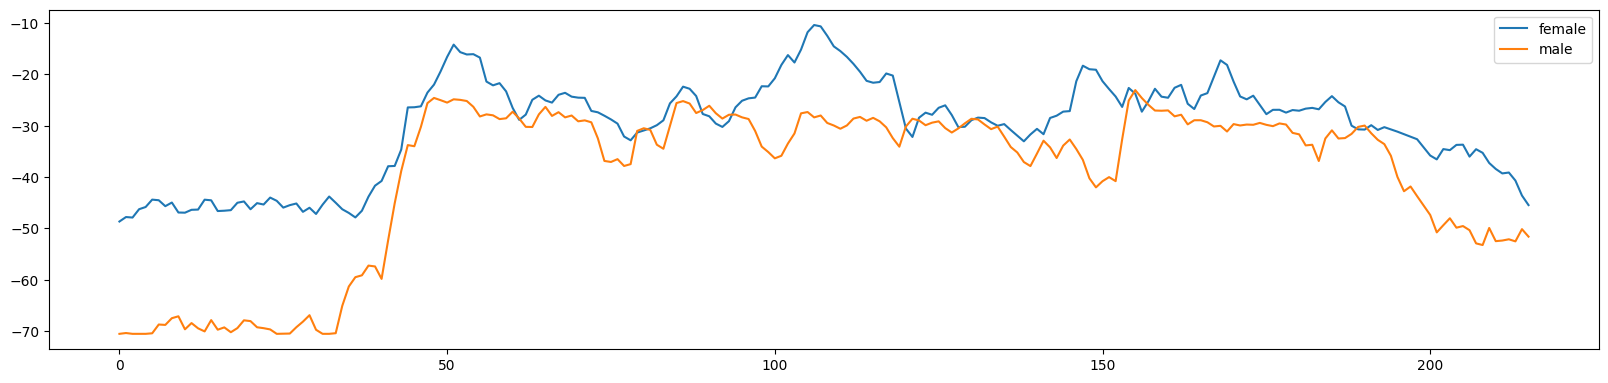

In [12]:
#coeffiecients for female voice
female = np.mean(librosa.feature.mfcc(y=Xf, sr=sample_ratef, n_mfcc=13), axis=0)
print(len(female))

#coefficients for male voice
male = np.mean(librosa.feature.mfcc(y=Xm, sr=sample_ratem, n_mfcc=13), axis=0)
print(len(male))

# audio wave
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
plt.plot(female, label='female')
plt.plot(male, label='male')
plt.legend()

Using Mel Spectrogram

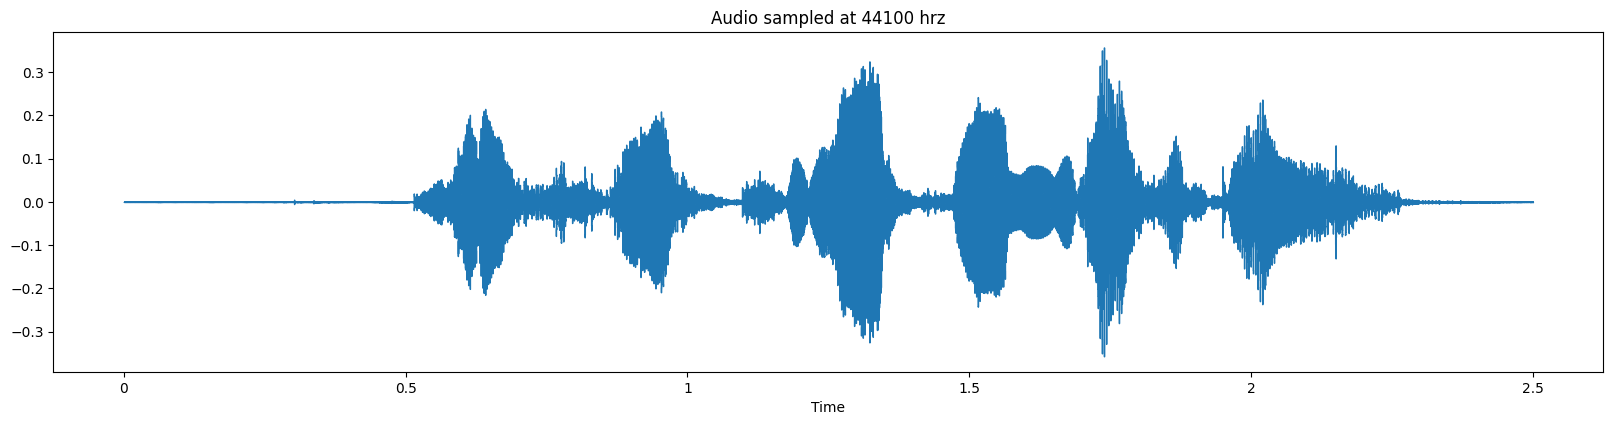

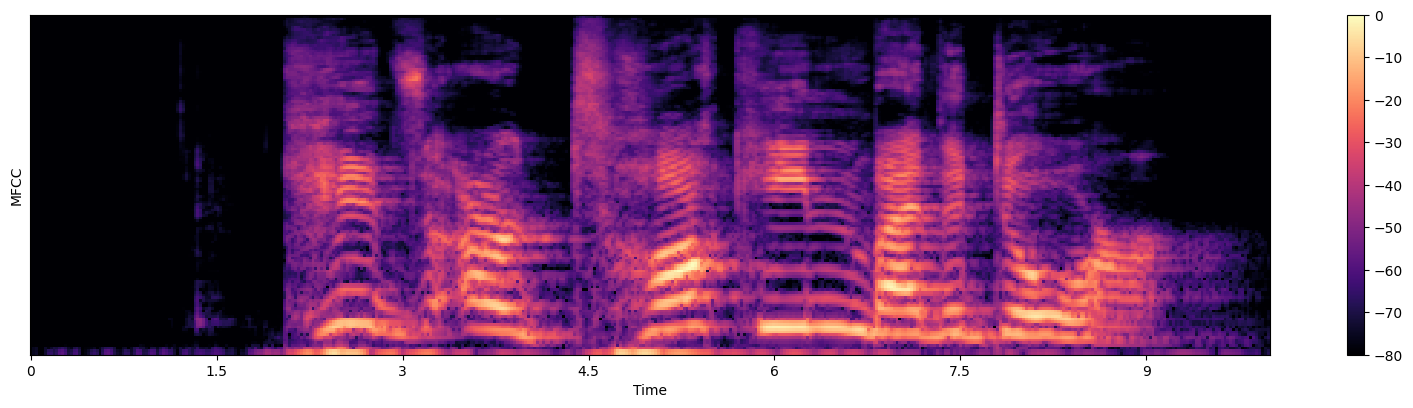

In [13]:
# Source - RAVDESS; Gender - Female; Emotion - Angry 
pathf = os.path.join(customized_path_to_project,"ravdess/data/Actor_08/03-01-05-02-01-01-08.wav")
Xf, sample_ratef = librosa.load(pathf,duration=2.5,sr=22050*2,offset=0.5)  
mel_spec = librosa.feature.melspectrogram(y=Xf, sr=22050*2, n_fft=1024, hop_length=256, n_mels=128, fmax=22050*2/2)
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

# audio wave
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.waveshow(Xf, sr=sample_ratef)
plt.title('Audio sampled at 44100 hrz')

# MFCC
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.specshow(mel_spec_db, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()
ipd.Audio(pathf)

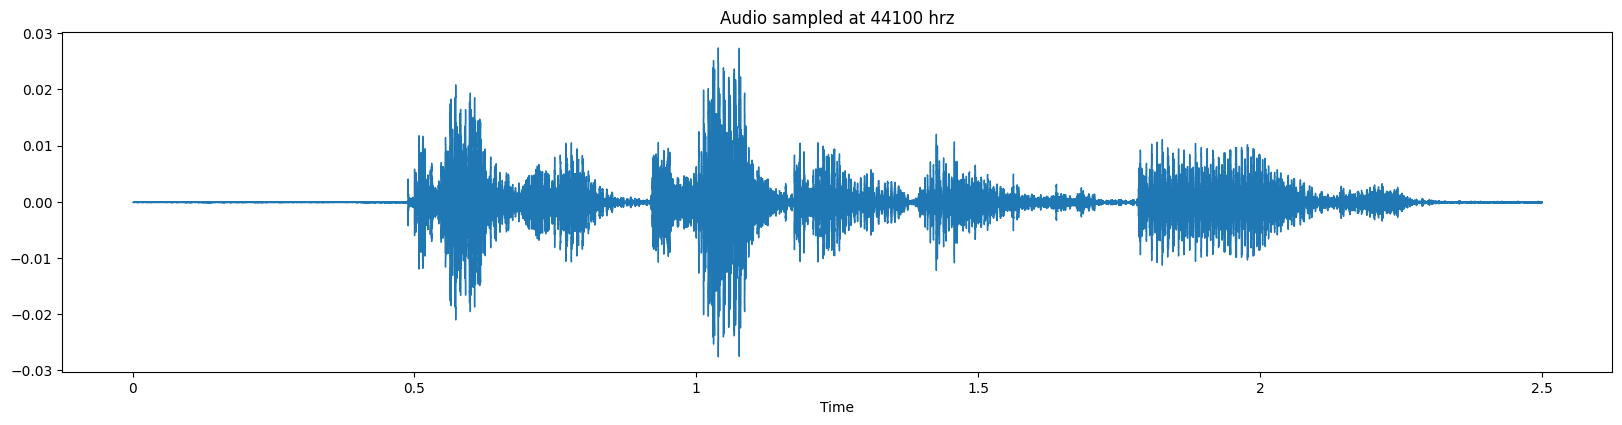

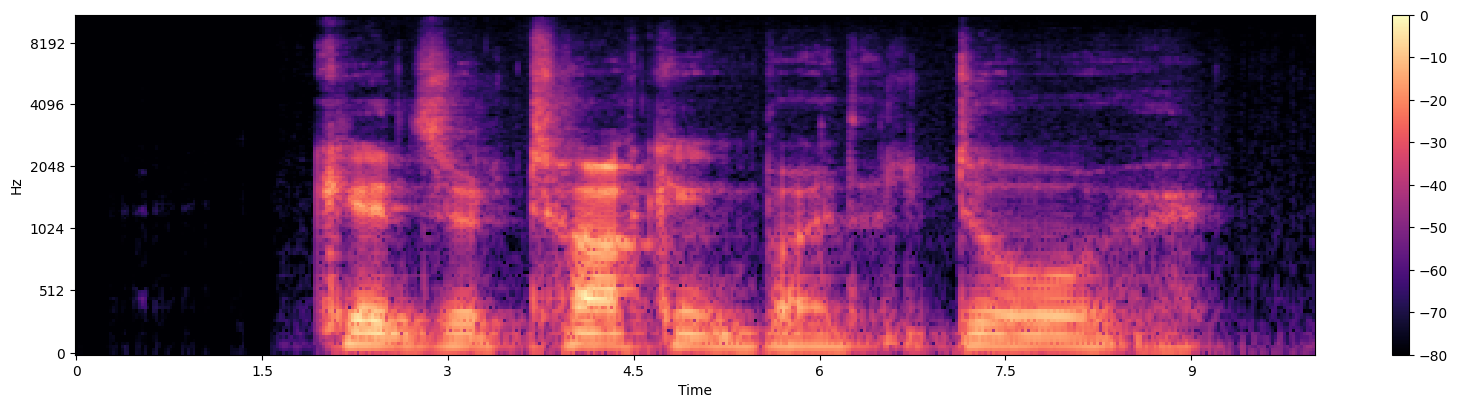

In [14]:
# Source - RAVDESS; Gender - Male; Emotion - Angry 
pathm = os.path.join(customized_path_to_project,"ravdess/data/Actor_09/03-01-05-01-01-01-09.wav")
Xm, sample_ratem = librosa.load(pathm,duration=2.5,sr=22050*2,offset=0.5)   
mel_spec = librosa.feature.melspectrogram(y=Xm, sr=22050*2, n_fft=1024, hop_length=256, n_mels=128, fmax=22050*2/2)
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

# audio wave
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.waveshow(Xm, sr=sample_ratem)
plt.title('Audio sampled at 44100 hrz')

# MEL
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.specshow(mel_spec_db, y_axis='mel', x_axis='time')
plt.colorbar()
ipd.Audio(pathm)

# Data Pre-processing (Run once)

In [15]:
'''Global Initializations'''
SAMPLE_RATE = 48000
DURATION = 3.0
os.makedirs(os.path.join(customized_path_to_project, "pkl_files", "CNN_Transformer"), exist_ok=True)

In [16]:
def MELSpectrogram(signal, sample_rate):
  mel_spec = librosa.feature.melspectrogram(y=signal, sr=sample_rate, n_fft=1024, hop_length=256, n_mels=128, fmax=sample_rate/2)
  mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
  return mel_spec_db

In [17]:
def AWGN(signal, num_bits=16, augmented_num=2, low=15, high=30): 
    len_signal = len(signal)
    # Generate White Gaussian noise
    noise = np.random.normal(size=(augmented_num, len_signal)) # shape: [augmented_num, len_signal]
    # Normalize signal and noise
    constant = 2.0**(num_bits-1)
    norm_signal = signal / constant
    norm_noise = noise / constant
    # Compute signal and noise power
    signal_power = np.sum(np.square(norm_signal)) / len_signal
    noise_power = np.sum(np.square(norm_noise), axis=1) / len_signal
    # Random SNR: Uniform [15, 30] in dB
    target_snr = np.random.randint(low, high)
    # Compute cov:(covariance matrix) for each noise 
    cov = np.sqrt((signal_power / noise_power) * 10 ** (- target_snr / 10))    
    cov = np.ones((len_signal, augmented_num)) * cov 
    # Generate noisy signal
    return signal + cov.T * noise

#### Processing male voices

In [18]:
# creating train, validation and test datarfame
from numpy.random import RandomState
df = pd.read_csv('/content/male.csv')
print(f"Total number of examples: {len(df)}")
train = df.sample(frac=0.7, random_state=200)
dev = df.loc[~df.index.isin(train.index)]
# splitting development set into val and test set
val = dev.iloc[:int(len(dev)//3)*2, :]
test = dev.iloc[int(len(dev)//3)*2:, :]
print(f"Total Number of examppe in training set: {len(train)}")
print(f"Total Number of examppe in validation set: {len(val)}")
print(f"Total Number of examppe in testing set: {len(test)}")

Total number of examples: 730
Total Number of examppe in training set: 511
Total Number of examppe in validation set: 146
Total Number of examppe in testing set: 73


In [19]:
df_features = pd.DataFrame(columns=["feature"])
df_path = pd.DataFrame(columns=['path'])
counter = 0

for p in tq.tqdm(train.path):
  audio, _ = librosa.load(p, duration=DURATION, offset=0.5, sr=SAMPLE_RATE)
  audio, _ = librosa.effects.trim(audio, top_db=30) # trimming silence 
  # audio, _ = librosa.effects.trim(audio, top_db=30) # trimming silence 
  temp_audio = np.zeros((int(SAMPLE_RATE*DURATION,)))
  temp_audio[:len(audio)] = audio
  audio_noise = AWGN(temp_audio)
  
  mel_spectrogram_o = MELSpectrogram(temp_audio, sample_rate=SAMPLE_RATE)  
  mel_spectrogram_n1 = MELSpectrogram(audio_noise[0,:], sample_rate=SAMPLE_RATE) 
  mel_spectrogram_n2 = MELSpectrogram(audio_noise[1,:], sample_rate=SAMPLE_RATE)  

  for j, signal in enumerate([mel_spectrogram_o, mel_spectrogram_n1, mel_spectrogram_n2]):       
    df_path.loc[j + counter] = p 
    df_features.loc[j + counter] = [signal]  
  counter += 3 

df = pd.concat([df_path, df_features], axis=1)
print(f"Shape of the dataframe:{df.shape}")
df.to_pickle("male_train.pkl")
!cp "/content/male_train.pkl" -r "/content/drive/MyDrive/apple_farm/pkl_files/CNN_Transformer/male_train.pkl"

  0%|          | 0/511 [00:00<?, ?it/s]

Shape of the dataframe:(1533, 2)


In [20]:
mel_spectrogram_o

array([[-80.        , -73.97051536, -67.69534667, ..., -80.        ,
        -80.        , -80.        ],
       [-80.        , -73.93359932, -67.52456829, ..., -80.        ,
        -80.        , -80.        ],
       [-80.        , -70.79221398, -63.07252889, ..., -80.        ,
        -80.        , -80.        ],
       ...,
       [-80.        , -80.        , -76.75929326, ..., -80.        ,
        -80.        , -80.        ],
       [-80.        , -80.        , -80.        , ..., -80.        ,
        -80.        , -80.        ],
       [-80.        , -80.        , -80.        , ..., -80.        ,
        -80.        , -80.        ]])

In [21]:
mel_spectrogram_n1

array([[-63.53576717, -56.05622204, -55.3880426 , ..., -56.16383378,
        -57.03737751, -71.35587909],
       [-63.24640259, -56.25165108, -55.40743955, ..., -56.21312968,
        -57.01941607, -68.56481498],
       [-57.91596415, -57.5211129 , -52.97938481, ..., -54.22206078,
        -54.10429295, -57.32751636],
       ...,
       [-60.97741429, -58.57807294, -59.75750042, ..., -57.41158613,
        -57.84483897, -58.68200316],
       [-61.80362828, -59.95161577, -59.89737392, ..., -60.4680784 ,
        -59.74962065, -60.79348108],
       [-63.48974504, -61.46017036, -61.86307118, ..., -61.79395518,
        -62.2656547 , -63.13933262]])

In [22]:
mel_spectrogram_n2

array([[-66.03763652, -57.99635431, -56.13881779, ..., -62.06305362,
        -64.50448463, -71.83474712],
       [-65.99472801, -57.82732917, -55.95551108, ..., -61.52267089,
        -63.82491917, -71.33556548],
       [-62.78439193, -53.38990797, -51.40058812, ..., -54.82025673,
        -56.53983679, -64.82581668],
       ...,
       [-61.90260916, -59.27390415, -60.81159851, ..., -58.3903696 ,
        -59.40432778, -58.69715703],
       [-59.65814665, -59.59343144, -61.36328204, ..., -57.07424043,
        -56.90417405, -57.58203622],
       [-61.86714131, -60.19803065, -60.0674942 , ..., -60.95985615,
        -60.22157605, -60.00832606]])

In [23]:
# validation
df_path =  pd.DataFrame(columns=["path"])
df_mel = pd.DataFrame(columns=["feature"])

for i, p in enumerate(tq.tqdm(val.path)):
  audio, _ = librosa.load(p, duration=DURATION, offset=0.5, sr=SAMPLE_RATE) 
  audio, _ = librosa.effects.trim(audio, top_db=30) # trimming silence 
  temp_audio = np.zeros((int(SAMPLE_RATE*DURATION,)))
  temp_audio[:len(audio)] = audio
  mel = MELSpectrogram(temp_audio, sample_rate=SAMPLE_RATE)
  df_path.loc[i] = p
  df_mel.loc[i]= [mel]

# df_mel = Normalize(df_mel)

df = pd.concat([df_path, df_mel], axis=1)
print(f"Shape of the dataframe:{df.shape}\n")
df.to_pickle("male_val.pkl")
!cp "/content/male_val.pkl" -r "/content/drive/MyDrive/apple_farm/pkl_files/CNN_Transformer/male_val.pkl"

# testing
df_path =  pd.DataFrame(columns=["path"])
df_mel = pd.DataFrame(columns=["feature"])

for i, p in enumerate(tq.tqdm(test.path)):
  audio, _ = librosa.load(p, duration=DURATION, offset=0.5, sr=SAMPLE_RATE)  
  temp_audio = np.zeros((int(SAMPLE_RATE*DURATION,)))
  temp_audio[:len(audio)] = audio
  mel = MELSpectrogram(temp_audio, sample_rate=SAMPLE_RATE)
  df_path.loc[i] = p
  df_mel.loc[i]= [mel]

# df_mel = Normalize(df_mel)

df = pd.concat([df_path, df_mel], axis=1)
print(f"Shape of the dataframe:{df.shape}\n")
df.to_pickle("male_test.pkl")
!cp "/content/male_test.pkl" -r "/content/drive/MyDrive/apple_farm/pkl_files/CNN_Transformer/male_test.pkl"

  0%|          | 0/146 [00:00<?, ?it/s]

Shape of the dataframe:(146, 2)



  0%|          | 0/73 [00:00<?, ?it/s]

Shape of the dataframe:(73, 2)



#### Processing female voices

In [24]:
# creating train, validation and test datarfame
from numpy.random import RandomState
df = pd.read_csv('/content/female.csv')
print(f"Total number of examples: {len(df)}")
train = df.sample(frac=0.7, random_state=200)
dev = df.loc[~df.index.isin(train.index)]
# splitting development set into val and test set
val = dev.iloc[:int(len(dev)//3)*2, :]
test = dev.iloc[int(len(dev)//3)*2:, :]
print(f"Total Number of examppe in training set: {len(train)}")
print(f"Total Number of examppe in validation set: {len(val)}")
print(f"Total Number of examppe in testing set: {len(test)}")

Total number of examples: 727
Total Number of examppe in training set: 509
Total Number of examppe in validation set: 144
Total Number of examppe in testing set: 74


In [25]:
df_features = pd.DataFrame(columns=["feature"])
df_path = pd.DataFrame(columns=['path'])
counter = 0

for p in tq.tqdm(train.path):
  audio, _ = librosa.load(p, duration=DURATION, offset=0.5, sr=SAMPLE_RATE)
  audio, _ = librosa.effects.trim(audio, top_db=30) # trimming silence 
  temp_audio = np.zeros((int(SAMPLE_RATE*DURATION,)))
  temp_audio[:len(audio)] = audio
  audio_noise = AWGN(temp_audio)
  
  mel_spectrogram_o = MELSpectrogram(temp_audio, sample_rate=SAMPLE_RATE)  
  mel_spectrogram_n1 = MELSpectrogram(audio_noise[0,:], sample_rate=SAMPLE_RATE)
  mel_spectrogram_n2 = MELSpectrogram(audio_noise[1,:], sample_rate=SAMPLE_RATE)  

  for j, signal in enumerate([mel_spectrogram_o, mel_spectrogram_n1, mel_spectrogram_n2]):       
    df_path.loc[j + counter] = p 
    df_features.loc[j + counter] = [signal]  
  counter += 3 

df = pd.concat([df_path, df_features], axis=1)
print(f"Shape of the dataframe:{df.shape}")
df.to_pickle("female_train.pkl")
!cp "/content/female_train.pkl" -r "/content/drive/MyDrive/apple_farm/pkl_files/CNN_Transformer/female_train.pkl"

  0%|          | 0/509 [00:00<?, ?it/s]

Shape of the dataframe:(1527, 2)


In [26]:
# validation
df_path =  pd.DataFrame(columns=["path"])
df_mel = pd.DataFrame(columns=["feature"])

for i, p in enumerate(tq.tqdm(val.path)):
  audio, _ = librosa.load(p, duration=DURATION, offset=0.5, sr=SAMPLE_RATE)  
  audio, _ = librosa.effects.trim(audio, top_db=30) # trimming silence 
  temp_audio = np.zeros((int(SAMPLE_RATE*DURATION,)))
  temp_audio[:len(audio)] = audio
  mel = MELSpectrogram(temp_audio, sample_rate=SAMPLE_RATE)
  df_path.loc[i] = p
  df_mel.loc[i]= [mel]

# df_mel = Normalize(df_mel)

df = pd.concat([df_path, df_mel], axis=1)
print(f"Shape of the dataframe:{df.shape}\n")
df.to_pickle("female_val.pkl")
!cp "/content/female_val.pkl" -r "/content/drive/MyDrive/apple_farm/pkl_files/CNN_Transformer/female_val.pkl"

# testing
df_path =  pd.DataFrame(columns=["path"])
df_mel = pd.DataFrame(columns=["feature"])

for i, p in enumerate(tq.tqdm(test.path)):
  audio, _ = librosa.load(p, duration=DURATION, offset=0.5, sr=SAMPLE_RATE)  
  temp_audio = np.zeros((int(SAMPLE_RATE*DURATION,)))
  temp_audio[:len(audio)] = audio
  mel = MELSpectrogram(temp_audio, sample_rate=SAMPLE_RATE)
  df_path.loc[i] = p
  df_mel.loc[i]= [mel]

# df_mel = Normalize(df_mel)

df = pd.concat([df_path, df_mel], axis=1)
print(f"Shape of the dataframe:{df.shape}\n")
df.to_pickle("female_test.pkl")
!cp "/content/female_test.pkl" -r "/content/drive/MyDrive/apple_farm/pkl_files/CNN_Transformer/female_test.pkl"

  0%|          | 0/144 [00:00<?, ?it/s]

Shape of the dataframe:(144, 2)



  0%|          | 0/74 [00:00<?, ?it/s]

Shape of the dataframe:(74, 2)



#Data Loader (Run)

In [27]:
# custom class to explore dataset
class Voice_dataset(Dataset):
  def __init__(self, pkl_location):    
    self.df = pd.read_pickle(pkl_location)  

  def normalize(self, data):
    return minmax_scale(data, feature_range=(0, 1))  

  def __len__(self):  # returns the length of the data set
     return len(self.df)

  def __getitem__(self, idx):  
    voice = dict()
    voice_labels = self.df.iloc[idx, 0].split("/")[-1].split(".")[0].split("-")       

    voice["emotion"] = int(voice_labels[2]) - 1    
    
    voice["features"] = self.df.iloc[idx, 1]       
    return voice

# Model (Run)

In [28]:
class CNNTransformer(nn.Module):

  def __init__(self, num_emotions):
    super().__init__()
    # conv block
    self.conv2Dblock = nn.Sequential(
        
            # 1. conv block
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1 ),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.3),
            # 2. conv block
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),
            nn.Dropout(p=0.3),
            # 3. conv block
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),
            nn.Dropout(p=0.3),
            # 4. conv block
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1 ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),
            nn.Dropout(p=0.3)
            )
    
    # Transformer block
    self.transf_maxpool = nn.MaxPool2d(kernel_size=[2,4], stride=[2,4])
    transf_layer = nn.TransformerEncoderLayer(d_model=64, nhead=4, dim_feedforward=512, dropout=0.4, activation='relu')
    self.transf_encoder = nn.TransformerEncoder(transf_layer, num_layers=4)

    # Linear softmax layer
    self.out_linear = nn.Linear(320, num_emotions)
    self.dropout_linear = nn.Dropout(p=0)
    self.out_softmax = nn.Softmax(dim=1)

  def forward(self,x):

    # conv embedding
    conv_embedding = self.conv2Dblock(x) #(b,channel,freq,time)
    conv_embedding = torch.flatten(conv_embedding, start_dim=1) # do not flatten batch dimension

    # transformer embedding
    x_reduced = self.transf_maxpool(x)
    x_reduced = torch.squeeze(x_reduced,1)
    x_reduced = x_reduced.permute(2,0,1) # requires shape = (time,batch,embedding)
    transf_out = self.transf_encoder(x_reduced)
    transf_embedding = torch.mean(transf_out, dim=0)

    # concatenate
    complete_embedding = torch.cat([conv_embedding, transf_embedding], dim=1) 

    # final Linear
    output_logits = self.out_linear(complete_embedding)
    output_logits = self.dropout_linear(output_logits)
    output_softmax = self.out_softmax(output_logits)
    return output_softmax

In [29]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNTransformer(num_emotions=8).cuda()
# summary(model, (1, 128, 563))

In [30]:
# print(model)

#Training (Male)

In [31]:
'''Initializations'''
## Output directory to save weights
output_dir = customized_path_to_project + '/checkpoints/'
os.makedirs(output_dir, exist_ok=True)

train_set = Voice_dataset(pkl_location="/content/drive/MyDrive/apple_farm/pkl_files/CNN_Transformer/male_train.pkl")
val_set = Voice_dataset(pkl_location="/content/drive/MyDrive/apple_farm/pkl_files/CNN_Transformer/male_val.pkl")
test_set = Voice_dataset(pkl_location="/content/drive/MyDrive/apple_farm/pkl_files/CNN_Transformer/male_test.pkl")
print(f"Number of training examples: {len(train_set)}\n Number of validation examples: {len(val_set)}\n Number of testing examples: {len(test_set)} ")

Number of training examples: 1533
 Number of validation examples: 146
 Number of testing examples: 73 


In [32]:
def print_test_result(emotions_dict):
  neutral = 0

  for i in range(8):
    emotion = i + 1
    if emotion not in emotions_dict:
      emotions_dict[emotion] = 0
    if emotion == 1 or emotion == 2:  
      neutral += emotions_dict[emotion]
    elif emotion == 3:
      happy = emotions_dict[emotion]
    elif emotion == 4:
      sad = emotions_dict[emotion]
    elif emotion == 5:
      angry = emotions_dict[emotion]
    elif emotion == 6:
      fearful = emotions_dict[emotion]
    elif emotion == 7:
      disgust = emotions_dict[emotion]
    elif emotion == 8:
      surprised = emotions_dict[emotion]

  total_count = {"neutral" : neutral, "happy" : happy, "sad" : sad, "angry" : angry, "fearful" : fearful, "disgust" : disgust, "surprised" : surprised}
  total = sum(total_count.values())

  for emotion_count in total_count.keys():
    print(f"{emotion_count} : {(total_count[emotion_count] / total) * 100:.2f}%")

  max_key = max(total_count, key = total_count.get)
  print(f"Max count : {max_key}")

In [33]:
# helper function for computing accuracy
def get_acc(pred, y):
    pred = pred.float()    
    y = y.float()    
    prediction=((y==pred).sum().float()/y.shape[0])*100
    return torch.round(prediction)

# helper function for computing model accuracy
def get_model_acc(model, loader, test=False, path=None):
  total_step = len(loader)  
  criterion = nn.CrossEntropyLoss().cuda()
  loss = 0

  if test is True:
    print("Loading best weights for testing")
    model.load_state_dict(torch.load(path))

  model.eval()
  with torch.no_grad():
    ys_emotions = list()    
    y_preds_emotions = list()     

    for data in loader:
      features = data["features"].unsqueeze(1).float().cuda()
      emotions = data["emotion"].cuda()      
      ys_emotions.append(emotions)     

      # predictions
      predictions = model(features)          
      loss += criterion(predictions, emotions)       
      y_preds_emotions.append(torch.argmax(predictions, dim=1))      

    Ys_Emotions = torch.cat(ys_emotions, dim=0)    
    Y_Preds_Emotions = torch.cat(y_preds_emotions, dim=0)     

    emotions = Y_Preds_Emotions.tolist()
    emotions_dict = dict(Counter(emotions))

    if test == True:
      print_test_result(emotions_dict)

  return get_acc(Y_Preds_Emotions, Ys_Emotions), loss/total_step

In [34]:
def train(train_set, val_set, save_path, num_epochs=100, batch_size=64, num_workers=8, lr=1e-4, log_step = 1, continue_training=False, path=None):   

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  writer = SummaryWriter(log_dir=output_dir+"runs/CNN_Transformer")  
  train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)  
  val_loader = DataLoader(val_set, batch_size=len(val_set), shuffle=False, num_workers=num_workers)
  print(f"Total number of training example: {len(train_set)}\n")
  print(f"Total number of validation example: {len(val_set)}\n")

  #initialization#
  best_acc = None
  model = CNNTransformer(num_emotions=8).cuda()
  optimizer =  optim.Adam(model.parameters(), lr = lr, betas=(0.5, 0.999), weight_decay=1e-4)
  total_step = len(train_loader)   
  criterion = nn.CrossEntropyLoss().cuda()
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=False)

  if continue_training == True:
    path = str(input("Enter model path: "))
    print("---Loading weights---")
    model.load_state_dict(torch.load(os.path.join(path)))

  print("---Training Model---") 

  for epoch in range(num_epochs):
    print(f"--- Epoch {epoch + 1} ---") 
    model.train()
    loss_epoch = 0
    accuracy = 0
    for itr, data in enumerate(train_loader):
      optimizer.zero_grad()

      features = data["features"].unsqueeze(1).float().cuda()      
      emotions = data["emotion"].cuda()      
      
      # predictions
      predictions = model(features) 


      # loss
      loss = criterion(predictions, emotions) 
      loss.backward()
      optimizer.step()
      loss_epoch += loss.item()

      # log performance
      if itr % log_step == 0:
        print(f"Printing running logs for epoch: {epoch+1} Step: {itr}/{total_step} ---> Loss: {loss}")        
    print("----------------------------------------------------")
    print(f"Loss for epoch {epoch +1} : {loss_epoch/total_step}")    

    print(f"Performing validation for epoch: {epoch + 1}")    
    train_sentiment_acc, t_loss = get_model_acc(model, train_loader)
    writer.add_scalar("Model/tarining_loss", t_loss, epoch)
    
    val_sentiment_acc, v_loss = get_model_acc(model, val_loader)
    writer.add_scalar("Model/val_sentiment_acc", val_sentiment_acc, epoch)
    writer.add_scalar("Model/val_loss", v_loss, epoch)

    print(f"Training loss: {t_loss} Training Accuracy for Voice Sentiment: {train_sentiment_acc} % ")
    print(f"Validation loss: {v_loss} Validation Accuracy for Voice Sentiment: {val_sentiment_acc} %")

    scheduler.step(v_loss)
    if best_acc == None:
      best_acc = val_sentiment_acc
    elif val_sentiment_acc > best_acc:
      best_acc = val_sentiment_acc
      print(f"Updating Best accuracy to: {best_acc} %")
      torch.save(model.state_dict(), os.path.join(save_path, f"best_model_epoch_{epoch+1}.pth"))
    print("-----------------------------------------------------\n")
  return model

In [35]:
save_path = os.path.join(output_dir, "weights", "CNN_Transformer", "Male")
os.makedirs(save_path, exist_ok=True)
model = train(train_set=train_set, val_set=val_set, save_path=save_path, num_epochs=150, log_step = 5, batch_size=124, num_workers=8, lr=0.001, continue_training=False)

Total number of training example: 1533

Total number of validation example: 146

---Training Model---
--- Epoch 1 ---


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Printing running logs for epoch: 1 Step: 0/13 ---> Loss: 2.0789051055908203
Printing running logs for epoch: 1 Step: 5/13 ---> Loss: 2.0706517696380615
Printing running logs for epoch: 1 Step: 10/13 ---> Loss: 2.087195634841919
----------------------------------------------------
Loss for epoch 1 : 2.076764235129723
Performing validation for epoch: 1
Training loss: 2.0675289630889893 Training Accuracy for Voice Sentiment: 14.0 % 
Validation loss: 2.075721025466919 Validation Accuracy for Voice Sentiment: 12.0 %
-----------------------------------------------------

--- Epoch 2 ---
Printing running logs for epoch: 2 Step: 0/13 ---> Loss: 2.054001569747925
Printing running logs for epoch: 2 Step: 5/13 ---> Loss: 2.0497992038726807
Printing running logs for epoch: 2 Step: 10/13 ---> Loss: 2.058122158050537
----------------------------------------------------
Loss for epoch 2 : 2.0530676658336935
Performing validation for epoch: 2
Training loss: 2.0577392578125 Training Accuracy for Voice 

#Testing Male Voices

(01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised)

In [36]:
best_path = os.path.join(output_dir, "weights", "CNN_Transformer", "Male", "best_model_epoch_70.pth")
test_loader = DataLoader(test_set, batch_size=len(test_set), shuffle=False, num_workers=8)
test_sentiment_acc, test_loss = get_model_acc(model, test_loader , test=True, path=best_path)

print(f"Testing loss: {test_loss:.2f} Testing Accuracy for Voice Sentiment: {test_sentiment_acc:.2f} %")

Loading best weights for testing
neutral : 16.44%
happy : 20.55%
sad : 20.55%
angry : 15.07%
fearful : 16.44%
disgust : 10.96%
surprised : 0.00%
Max count : happy
Testing loss: 1.74 Testing Accuracy for Voice Sentiment: 55.00 %


# Training (Female)

In [37]:
'''Initializations'''
## Output directory to save weights
output_dir = customized_path_to_project + '/checkpoints/'
os.makedirs(output_dir, exist_ok=True)

train_set = Voice_dataset(pkl_location="/content/drive/MyDrive/apple_farm/pkl_files/CNN_Transformer/female_train.pkl")
val_set = Voice_dataset(pkl_location="/content/drive/MyDrive/apple_farm/pkl_files/CNN_Transformer/female_val.pkl")
test_set = Voice_dataset(pkl_location="/content/drive/MyDrive/apple_farm/pkl_files/CNN_Transformer/female_test.pkl")
print(f"Number of training examples: {len(train_set)}, Number of validation examples: {len(val_set)}, Number of testing examples: {len(test_set)} ")

Number of training examples: 1527, Number of validation examples: 144, Number of testing examples: 74 


In [38]:
save_path = os.path.join(output_dir, "weights", "CNN_Transformer", "Female")
os.makedirs(save_path, exist_ok=True)
model = train(train_set=train_set, val_set=val_set, save_path=save_path, num_epochs=150, log_step = 5, batch_size=124, num_workers=8, lr=0.001, continue_training=False)

Total number of training example: 1527

Total number of validation example: 144

---Training Model---
--- Epoch 1 ---


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Printing running logs for epoch: 1 Step: 0/13 ---> Loss: 2.064286231994629
Printing running logs for epoch: 1 Step: 5/13 ---> Loss: 2.0678229331970215
Printing running logs for epoch: 1 Step: 10/13 ---> Loss: 2.1139981746673584
----------------------------------------------------
Loss for epoch 1 : 2.068166494369507
Performing validation for epoch: 1
Training loss: 2.066671848297119 Training Accuracy for Voice Sentiment: 14.0 % 
Validation loss: 2.062917709350586 Validation Accuracy for Voice Sentiment: 14.0 %
-----------------------------------------------------

--- Epoch 2 ---
Printing running logs for epoch: 2 Step: 0/13 ---> Loss: 2.064413547515869
Printing running logs for epoch: 2 Step: 5/13 ---> Loss: 2.0497541427612305
Printing running logs for epoch: 2 Step: 10/13 ---> Loss: 2.0283360481262207
----------------------------------------------------
Loss for epoch 2 : 2.032332970545842
Performing validation for epoch: 2
Training loss: 2.0296905040740967 Training Accuracy for Voic

# Testing Female Voices

In [39]:
best_path = os.path.join(output_dir, "weights", "CNN_Transformer", "Female", "best_model_epoch_34.pth")
test_loader = DataLoader(test_set, batch_size=len(test_set), shuffle=False, num_workers=8)
test_sentiment_acc, test_loss = get_model_acc(model, test_loader , test=True, path=best_path)
print(f"Testing loss: {test_loss:.2f} Testing Accuracy for Voice Sentiment: {test_sentiment_acc:.2f} %")

Loading best weights for testing
neutral : 32.43%
happy : 18.92%
sad : 1.35%
angry : 10.81%
fearful : 20.27%
disgust : 16.22%
surprised : 0.00%
Max count : neutral
Testing loss: 1.72 Testing Accuracy for Voice Sentiment: 55.00 %
